# Metcouncil POPULATION SYNTHESIS
## VALIDATION OF METRICS


In [6]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from synthpop.recipes.starter2 import Starter
from synthpop.census_helpers import Census
import warnings
warnings.filterwarnings('ignore')

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import geopandas as gpd

### Synthesized Data

In [9]:
state='IL'
county='Cook'
c = Census(os.environ["CENSUS"])
county_id=c.try_fips_lookup(state,county+' County')['County ANSI']

In [99]:
hh_synth = pd.read_csv('./data/final_hh.csv', index_col='household_id', dtype={'serialno':'str',
                                                                                            'state':'str',
                                                                                            'county':'str',
                                                                                            'tract':'str',
                                                                                            'block_group':'str'})
hh_synth=hh_synth[hh_synth['county']==county_id]
p_synth = pd.read_csv('./data/final_pp.csv',index_col='person_id', dtype={'serialno':'str'})
p_synth=p_synth[p_synth['household_id'].isin(hh_synth.index)]
# making a geoid column to map the discrepancy later and for the groupby
hh_synth['geoid']=hh_synth['state'].astype(str) + hh_synth['county'].astype(str) + hh_synth['tract'].astype(str) + hh_synth['block_group'].astype(str)
print ('Loaded {:,} household records.'.format(len(hh_synth)))
print ('Loaded {:,} person records.'.format(len(p_synth)))

Loaded 1,966,356 household records.
Loaded 5,086,242 person records.


In [11]:
hh_synth.head()

,serialno,persons,group_quarters,building_type,cars,income,race_of_head,hispanic_head,age_of_head,workers,children,tenure,recent_mover,block_id,state,county,tract,block_group,test_tract,geoid
household_id,,,,,,,,,,,,,,,,,,,,
0,2012000840650,2,1,4.0,0.0,112000.0,1,no,36,2.0,NaN,2,0,170312421001012,17,031,242100,1,242100,170312421001
1,2013000530089,1,1,5.0,0.0,31000.0,1,no,55,1.0,NaN,2,0,170312421001002,17,031,242100,1,242100,170312421001
2,2013000070436,1,1,6.0,0.0,35000.0,1,no,35,1.0,NaN,2,0,170312421001007,17,031,242100,1,242100,170312421001
3,2013001005364,1,1,4.0,0.0,60000.0,1,no,58,1.0,NaN,2,0,170312421001008,17,031,242100,1,242100,170312421001
4,2011001129911,1,1,4.0,0.0,11200.0,1,no,50,1.0,NaN,2,0,170312421001003,17,031,242100,1,242100,170312421001


In [12]:
p_synth.head()

,member_id,age,relate,edu,sex,hours,hispanic,earning,race_id,hispanic.1,student,work_at_home,worker,self_employed,unemployed,nilf,county,household_id
person_id,,,,,,,,,,,,,,,,,,
0,1,30,0,21.0,1,45.0,1,59000.0,1,no,0,0,1,0,0,0,31,54
1,2,30,1,21.0,2,35.0,1,35000.0,1,no,0,0,1,0,0,0,31,54
2,2,28,12,21.0,1,50.0,1,100000.0,1,no,1,0,1,0,0,0,31,136
3,2,28,12,21.0,1,50.0,1,100000.0,1,no,1,0,1,0,0,0,31,137
4,2,28,12,21.0,1,50.0,1,100000.0,1,no,1,0,1,0,0,0,31,289


### Getting Marginal Distribution
Now lets get our same dataset we used to base the synthesis off of and format it for use in validating the synthesised data versus the expected data.

In order to download census data, you need a census API key. If you do not yet have a key you may request one here from the census. Afterwards, set the key as a environmental variable on your machine and call it 'CENSUS'.

In [81]:
# The os library reads the environmental variable saved on your machine
def key():
    return os.environ['CENSUS']

If you are unable set your key manually you may run this below to set it in your environmental variables, replace [API KEY] with your key.

In [53]:
# os.environ['CENSUS'] = [API KEY]

Download the data and filter by the state fips code and drop block groups with zero househlds and persons

In [82]:
starter = Starter(key(), state, county+' County', acsyear= 2013)

geog = starter.c.try_fips_lookup(state,county+' County')

ind = pd.Series([geog[0]], index=["state"])

hh_target=starter.get_household_marginal_for_geography(ind)
p_target=starter.get_person_marginal_for_geography(ind)

# add state fips code
state_fips = pd.Series([geog[0]], index=["state"])[0]
hh_target = pd.concat([hh_target], keys=[state_fips], names=['state'])
p_target = pd.concat([p_target], keys=[state_fips], names=['state'])

# drop census block groups with zero household
hh_target2=hh_target[hh_target['hh_age_of_head'].sum(axis=1)>0]
p_target2=p_target[p_target['person_sex'].sum(axis=1)>0]


Let's look at the marginal tables that we will use as our target for validation

In [15]:
hh_target2.head()

cat_name                        hh_age_of_head           hh_cars       \
cat_value                            gt35-lt65 gt65 lt35    none  one   
state county tract  block group                                         
17    031    242100 1                       89   27  210      65  173   
                    2                      261   19  376     132  350   
                    3                      393    9  295     140  371   
             242200 1                      365   13  393     165  441   
                    2                      373   58  459     190  509   

cat_name                                    hh_children        hh_income  \
cat_value                       two or more          no  yes gt100-lt150   
state county tract  block group                                            
17    031    242100 1                    85         283   43          63   
                    2                   173         527  129         115   
                    3                   184         594  103         162   
             242200 1                   163         575  196         140   
                    2                   189         736  154         119   

cat_name                               ... hispanic_head      seniors      \
cat_value                       gt150  ...            no  yes      no yes   
state county tract  block group        ...                                  
17    031    242100 1             104  ...           297   29     289  37   
                    2             190  ...           501  155     637  19   
                    3             277  ...           631   66     678  19   
             242200 1             216  ...           644  127     758  13   
                    2             273  ...           765  125     823  67   

cat_name                        sf_detached        tenure_mover             \
cat_value                                no  yes own not recent own recent   
state county tract  block group                                              
17    031    242100 1                   317    9            153          0   
                    2                   656    0            299          9   
                    3                   660   37            323         15   
             242200 1                   646  125            261          7   
                    2                   822   68            341         17   

cat_name                                                     
cat_value                       rent not recent rent recent  
state county tract  block group                              
17    031    242100 1                       127          46  
                    2                       312          36  
                    3                       341          18  
             242200 1                       432          71  
                    2                       445          87  

[5 rows x 34 columns]

In [16]:
p_target2.head()

cat_name                            hispanic               person_age  \
cat_value                                 no         yes 19 and under   
state county tract  block group                                         
17    031    030200 3             988.000000   76.000000     260.0000   
                    4            1201.042123  605.957877     344.9907   
             030300 1             957.000000  349.000000     279.0000   
                    2             764.000000  861.000000     387.0000   
             030400 1            1073.000000  377.000000     274.0000   

cat_name                                                             \
cat_value                          20 to 35    35 to 60    above 60   
state county tract  block group                                       
17    031    030200 3            191.000000  427.000000  186.000000   
                    4            789.821116  569.382932  102.805252   
             030300 1            307.000000  533.000000  187.000000   
                    2            396.000000  567.000000  275.000000   
             030400 1            418.000000  471.000000  287.000000   

cat_name                         person_sex                    race  \
cat_value                            female        male       asian   
state county tract  block group                                       
17    031    030200 3            479.000000  585.000000   89.000000   
                    4            997.408643  809.591357   10.873632   
             030300 1            533.000000  773.000000  186.000000   
                    2            797.000000  828.000000   59.000000   
             030400 1            794.000000  656.000000  106.000000   

cat_name                                                              
cat_value                             black       other        white  
state county tract  block group                                       
17    031    030200 3              0.000000    0.000000   975.000000  
                    4            154.207877  163.104486  1478.814004  
             030300 1            302.000000   91.000000   727.000000  
                    2             77.000000  351.000000  1138.000000  
             030400 1            194.000000  144.000000  1006.000000

## Validation for total households and total population by geography¶


### 1- Regroup synthetic tables by geography
To obtain number of households and number of persons per blockgroup. These synthetic values will be evaluated with the ACS marginals or expected values.

In [104]:
# join hh table with p table to get a column that says the geograpghy of the person 
hh_synth=hh_synth.reset_index()
p_synth = p_synth.reset_index()
p_synth= p_synth.merge(hh_synth, how='left', on='household_id', suffixes=('','_ignore'))
p_synth=p_synth.fillna(value=0, axis=1)
hh_synth=hh_synth.fillna(value=0, axis=1)
# Number of generated households per blockgroup
hh_synth_total=hh_synth.groupby(['geoid']).size().to_frame(name = 'num_of_hh_synth')
# Number of generated population per blockgroup
p_synth_total=p_synth.groupby(['geoid']).size().to_frame(name = 'pop_synth')

### 2- Regroup target tables by geography:
To obtain number of households and number of persons per blockgroup. This value is the expected value (Marginal).

In [105]:
hh_target=hh_target2.hh_children.sum(axis=1).to_frame(name = 'num_of_hh_target')
p_target=p_target2['hispanic'].sum(axis=1).to_frame(name = 'pop_target')

#Make sure the geoid column is string type and matches the synth tables
#For household table
hh_target=hh_target.reset_index()
hh_target['geoid']=hh_target['state'].astype(str)+hh_target['county'].astype(str)+hh_target['tract'].astype(str)+hh_target['block group'].astype(str)
hh_target=hh_target[['num_of_hh_target','geoid']]
#For persons table
p_target=p_target.reset_index()
p_target['geoid']=p_target['state'].astype(str)+p_target['county'].astype(str)+p_target['tract'].astype(str)+p_target['block group'].astype(str)
p_target=p_target[['pop_target','geoid']]

KeyError: 'hispanic'

### 3- Join the target and synth tables with fips code 
### 4- Calculate the percentage difference of totals

#### HOUSEHOLDS

In [19]:
hh_target.set_index('geoid',inplace=True)
hh_val = pd.merge(hh_synth_total, hh_target,left_index=True, right_index=True)
hh_val['pct_hh_diff']=(hh_val['num_of_hh_target']-hh_val['num_of_hh_synth'])/hh_val['num_of_hh_target']*100
hh_val.head()

,num_of_hh_synth,num_of_hh_target,pct_hh_diff
geoid,,,
170310101001,267,312,14.423077
170310101002,1009,833,-21.128451
170310101003,1026,1061,3.298775
170310102011,547,619,11.631664
170310102012,1453,1673,13.150030


#### PERSONS

In [ ]:
p_target.set_index('geoid',inplace=True)
pop_val = pd.merge(p_synth_total, p_target,left_index=True, right_index=True)
pop_val['pct_pop_diff']=(pop_val['pop_target']-pop_val['pop_synth'])/pop_val['pop_target']*100
pop_val.head()

## VALIDATION PLOTS
Now lets plot the differences between the two datasets
### HOUSEHOLDS

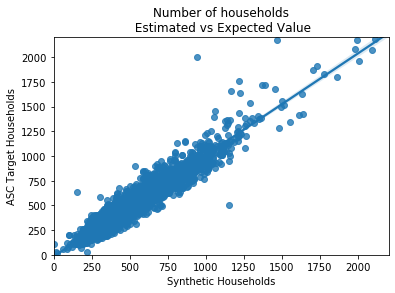

In [21]:
ax = sns.regplot(x="num_of_hh_synth", y="num_of_hh_target", data=hh_val)
plt.xlim(0, 2200)
plt.ylim(0, 2200)
plt.xlabel('Synthetic Households')
plt.ylabel('ASC Target Households')
ax.set_title('Number of households\n Estimated vs Expected Value')
plt.show()

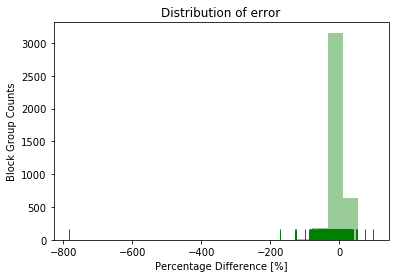

In [22]:
ax=sns.distplot(hh_val['pct_hh_diff'], kde=False, rug=True,bins=20,color= "g")
ax.set_ylabel('Block Group Counts')
plt.title('Distribution of error')
ax.set_xlabel('Percentage Difference [%]')
plt.show()

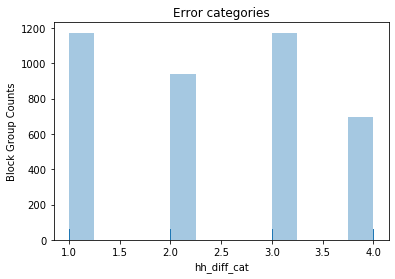

In [23]:
# categorize the discripancy column to visualize it
hh_val['hh_diff_cat']=hh_val['pct_hh_diff'].map(lambda x: 4 if abs(x)>20 else (3 if abs(x)>10 else (2 if abs(x)>5 else 1)))
ax=sns.distplot(hh_val['hh_diff_cat'],kde=False, rug=True)
ax.set_ylabel('Block Group Counts')
plt.title('Error categories')
plt.show()

### PERSONS

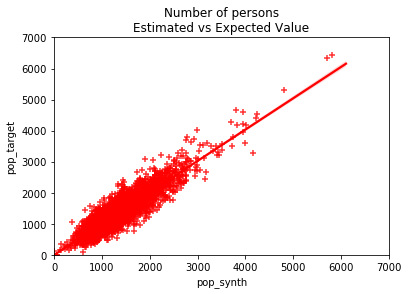

In [24]:
ax = sns.regplot(x="pop_synth", y="pop_target", data=pop_val, color='r',marker='+')
plt.xlim(0, 7000)
plt.ylim(0, 7000)
ax.set_title('Number of persons\nEstimated vs Expected Value')
plt.show()

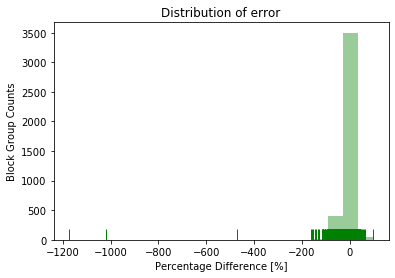

In [25]:
ax=sns.distplot(pop_val['pct_pop_diff'], kde=False, rug=True,bins=20,color= "g")
plt.title('Distribution of error')
ax.set_ylabel('Block Group Counts')
ax.set_xlabel('Percentage Difference [%]')
plt.show()

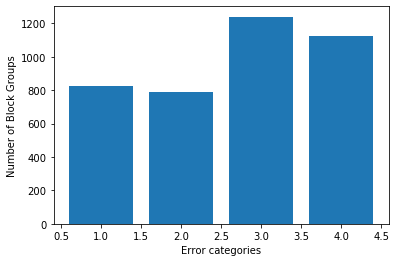

In [26]:
# categorize the discripancy column to visualize it
pop_val['pop_diff_cat']=pop_val['pct_pop_diff'].map(lambda x: 4 if abs(x)>20 else (3 if abs(x)>10 else (2 if abs(x)>5 else 1)))
a=pop_val['pop_diff_cat'].value_counts().to_frame()
plt.bar(a.index, a['pop_diff_cat'])
plt.xlabel('Error categories')
plt.ylabel('Number of Block Groups')
plt.show()

# Mapping the error by block group
With the blocks shapefile located in the data/directory, let's map the difference values

In [27]:
blocks = gpd.read_file('/home/data/chi/tl_2017_17_tabblock10.shp')
blocks.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYPE,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,17,021,958700,4176,170219587004176,Block 4176,G5040,R,None,None,S,0,219026,+39.3725281,-089.0927334,"POLYGON ((-89.09852699999999 39.371416, -89.09..."
1,17,201,004003,1044,172010040031044,Block 1044,G5040,R,None,None,S,0,45258,+42.4688210,-089.0777438,"POLYGON ((-89.078346 42.467526, -89.0782859999..."
2,17,201,000200,3002,172010002003002,Block 3002,G5040,U,75718,U,S,216076,17947,+42.3228892,-089.0350716,"POLYGON ((-89.03724299999999 42.318589, -89.03..."
3,17,179,020100,3039,171790201003039,Block 3039,G5040,U,68509,U,S,0,28113,+40.6847558,-089.5910001,POLYGON ((-89.59206999999999 40.68506199999999...
4,17,001,010500,2099,170010105002099,Block 2099,G5040,R,None,None,S,0,103125,+39.9347482,-091.4208457,"POLYGON ((-91.42410799999999 39.93575, -91.418..."


In [39]:
blocks['geoid'] = blocks['GEOID10'].map(lambda x: str(x)[:12])
b_groups = blocks.dissolve(by = 'geoid')

In [40]:
#Merge the population values (synthetic and target) to the geopanda with the geoid
pop_val= pop_val.reset_index()
blocks_pp = pd.merge(b_groups,pop_val, how='outer',on='geoid')
blocks_pp = blocks_pp[blocks_pp.pop_synth.isna() == False]
blocks_pp['abs_pct_pop_diff'] = np.abs(blocks_pp.pct_pop_diff)

#Merge the household values (synthetic and target) to the geopanda with the geoid
hh_val= hh_val.reset_index()
blocks_p_hh = pd.merge(blocks_pp,hh_val, how='outer', on='geoid')
blocks_p_hh = blocks_p_hh[blocks_p_hh.num_of_hh_synth.isna() == False]
blocks_p_hh['abs_pct_hh_diff'] = np.abs(blocks_p_hh.pct_hh_diff)

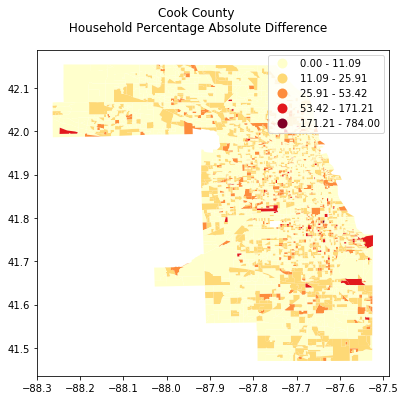

In [42]:
#Plot difference column for Households
f, ax = plt.subplots(1, figsize=(18, 6))
ax=blocks_p_hh.plot(column='abs_pct_hh_diff', cmap='YlOrRd',legend=True, axes=ax, scheme= 'fisher_jenks')
f.suptitle('{} County\n Household Percentage Absolute Difference'.format(county))
plt.show()

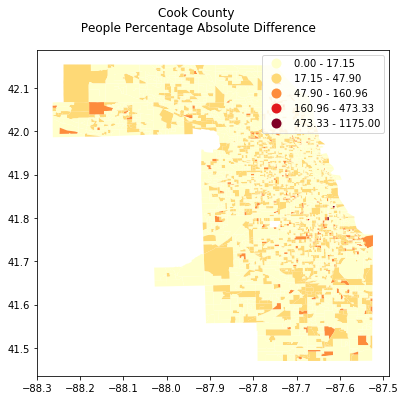

In [43]:
#Plot the difference column for PEOPLE
f, ax = plt.subplots(1, figsize=(18, 6))
ax=blocks_p_hh.plot(column='abs_pct_pop_diff', cmap='YlOrRd',legend=True, axes=ax, scheme= 'fisher_jenks')
f.suptitle('{} County\n People Percentage Absolute Difference'.format(county))
plt.show()

Let's look at the blocks that show a high absolute percentage of difference between the synthetic results and the agreggate data form the ACS

In [44]:
#BLOCKS THAT HAVE A HIGH ABSOLUTE PERCENTAGE DIFFERENCE IN SYNTHETIC RESULTS AND TARGETS FOR HOUSEHOLDS AND PEOPLE
blocks_p_hh[(blocks_p_hh.abs_pct_pop_diff > 25)|(blocks_p_hh.abs_pct_hh_diff > 5)][['geoid','num_of_hh_synth','num_of_hh_target','abs_pct_hh_diff','pop_synth','pop_target','abs_pct_pop_diff']].sort_values(['abs_pct_pop_diff','abs_pct_pop_diff'])

,geoid,num_of_hh_synth,num_of_hh_target,abs_pct_hh_diff,pop_synth,pop_target,abs_pct_pop_diff
1053,170313102001,263,328,19.817073,671.0,671.0,0.000000
1370,170315303002,282,203,38.916256,823.0,823.0,0.000000
2304,170318047133,232,216,7.407407,640.0,640.0,0.000000
2512,170318070001,952,1012,5.928854,2669.0,2669.0,0.000000
2712,170318118001,290,244,18.852459,979.0,979.0,0.000000
2779,170318133011,465,420,10.714286,1651.0,1651.0,0.000000
2877,170318154004,598,561,6.595365,1356.0,1356.0,0.000000
2878,170318155001,492,467,5.353319,1505.0,1505.0,0.000000
3039,170318195001,328,306,7.189542,668.0,668.0,0.000000
890,170312503003,549,393,39.694656,1631.0,1630.0,0.061350


# Attributes Validation
In this section, the synthetic attributes will be compared with the target ones. This validation is done on controlled and uncontrolled variables. <br> 
Household tables are: hh_target2, hh_synth.<br> Person level tables are: p_target, p_synth

Create categories to compare with target (ACS) table on Household Tables

In [53]:
hh_synth['hispanic_head'].value_counts()

no     1642712
yes     323644
Name: hispanic_head, dtype: int64

In [61]:
hh_synth2=hh_synth[['household_id','geoid','persons','children','workers','income','cars',
                    'race_of_head','age_of_head', 'tenure', 'recent_mover', 'hispanic_head']]

def age_of_head(x):
    if x <=35:
        return 'lt35'
    elif (x >35) & (x <=65):
        return 'gt35-lt65'
    else:
        return 'gt65'
def income(x):
    if x <=30000:
        return 'lt30'
    elif (x >30000) & (x <=60000):
        return 'gt30-lt60'
    elif(x >60000) & (x <=100000):
        return 'gt60-lt100'
    elif (x >100000) & (x <=150000):
        return 'gt100-lt150'
    else:
        return 'gt150'
def size(x):
    if x == 1:
        return 'one'
    elif x == 2:
        return 'two'
    elif x == 3:
        return 'three'
    else:
        return 'four or more' 
def workers(x):
    if x == 0.0:
        return 'none'
    elif x == 1.0:
        return 'one'
    else:
        return 'two or more'
def cars(x):
    if x == 0:
        return 'none'
    elif x == 1:
        return 'one'
    else:
        return 'two or more'
def tenure(x):
    if x == 1:
        return 'owner'
    elif x == 2:
        return 'renter'
    else:
        return np.nan
def recent_mover(x):
    if x == 1:
        return 'yes'
    elif x == 0:
        return 'no'
    else:
        return np.nan
def children(x):
    if (isinstance(x, int)) | (isinstance(x, float)): 
        if x >= 1:
            return 'yes'
        elif x == 0:
            return 'no'
    else:
        return x
def hispanic(x):
    if x == 1:
        return 'yes'
    elif x == 0:
        return 'no'
    else:
        return np.nan



In [63]:
hh_synth2.head()

,household_id,geoid,persons,children,workers,income,cars,race_of_head,age_of_head,tenure,recent_mover,hispanic_head
0,0,170312421001,2,0.0,2.0,112000.0,0.0,1,36,2,0,no
1,1,170312421001,1,0.0,1.0,31000.0,0.0,1,55,2,0,no
2,2,170312421001,1,0.0,1.0,35000.0,0.0,1,35,2,0,no
3,3,170312421001,1,0.0,1.0,60000.0,0.0,1,58,2,0,no
4,4,170312421001,1,0.0,1.0,11200.0,0.0,1,50,2,0,no


In [64]:
hh_synth2['hh_race_of_head']= hh_synth2.race_of_head.map({6:'asian', 1:'white', 9:'other', 
                                                          7:'other', 2:'black', 8:'other', 5:'other',
                                                          3:'other',4:'other'})
hh_synth2['hh_size'] = hh_synth2.persons.map(size)
hh_synth2['hh_age_of_head'] = hh_synth2.age_of_head.map(age_of_head)
hh_synth2['hh_children'] = hh_synth2.children.map(children)
hh_synth2['hh_workers'] = hh_synth2.workers.map(workers)
hh_synth2['hh_income'] = hh_synth2.income.map(income)
hh_synth2['hh_cars'] = hh_synth2.cars.map(cars)
hh_synth2['recent_mover'] = hh_synth2.recent_mover.map(recent_mover)
hh_synth2['tenure'] = hh_synth2.tenure.map(tenure)
# hh_synth2['hispanic_head'] = hh_synth2.hispanic_head.map(hispanic)

# Make dummy columns
cols_to_transform=['hh_size','hh_workers','hh_cars','hh_age_of_head',
                   'hh_race_of_head','hh_income','hh_children','tenure','recent_mover','hispanic_head']
hh_synth2=pd.get_dummies(hh_synth2,columns = cols_to_transform)
pd.set_option('display.max_columns',500)
hh_synth2.head()

,household_id,geoid,persons,children,workers,income,cars,race_of_head,age_of_head,hh_size_four or more,hh_size_one,hh_size_three,hh_size_two,hh_workers_none,hh_workers_one,hh_workers_two or more,hh_cars_none,hh_cars_one,hh_cars_two or more,hh_age_of_head_gt35-lt65,hh_age_of_head_gt65,hh_age_of_head_lt35,hh_race_of_head_asian,hh_race_of_head_black,hh_race_of_head_other,hh_race_of_head_white,hh_income_gt100-lt150,hh_income_gt150,hh_income_gt30-lt60,hh_income_gt60-lt100,hh_income_lt30,hh_children_no,hh_children_yes,tenure_owner,tenure_renter,recent_mover_no,recent_mover_yes,hispanic_head_no,hispanic_head_yes
0,0,170312421001,2,0.0,2.0,112000.0,0.0,1,36,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0
1,1,170312421001,1,0.0,1.0,31000.0,0.0,1,55,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0
2,2,170312421001,1,0.0,1.0,35000.0,0.0,1,35,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0
3,3,170312421001,1,0.0,1.0,60000.0,0.0,1,58,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,1,0
4,4,170312421001,1,0.0,1.0,11200.0,0.0,1,50,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,1,1,0,1,0


In [65]:
# Aggregate Distribution of syntehtic results by geoid (block group)
synth_hh_totals=hh_synth2.groupby('geoid').agg(sum)
synth_hh_totals1=synth_hh_totals.sum().to_frame().T
synth_hh_totals.head()

,household_id,persons,children,workers,income,cars,race_of_head,age_of_head,hh_size_four or more,hh_size_one,hh_size_three,hh_size_two,hh_workers_none,hh_workers_one,hh_workers_two or more,hh_cars_none,hh_cars_one,hh_cars_two or more,hh_age_of_head_gt35-lt65,hh_age_of_head_gt65,hh_age_of_head_lt35,hh_race_of_head_asian,hh_race_of_head_black,hh_race_of_head_other,hh_race_of_head_white,hh_income_gt100-lt150,hh_income_gt150,hh_income_gt30-lt60,hh_income_gt60-lt100,hh_income_lt30,hh_children_no,hh_children_yes,tenure_owner,tenure_renter,recent_mover_no,recent_mover_yes,hispanic_head_no,hispanic_head_yes
geoid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
170310101001,129315762,575,115.0,326.0,18290514.0,226.0,516,12990,39.0,103.0,30.0,95.0,53.0,111.0,103.0,107.0,101.0,59.0,230.0,4.0,33.0,0.0,121.0,18.0,128.0,92.0,11.0,1.0,38.0,125.0,201.0,66.0,116.0,151.0,267.0,0.0,244.0,23.0
170310101002,489185758,2174,545.0,1176.0,45044139.0,731.0,2181,47866,155.0,430.0,150.0,274.0,229.0,427.0,353.0,479.0,363.0,167.0,760.0,53.0,196.0,14.0,497.0,84.0,414.0,107.0,26.0,112.0,152.0,612.0,670.0,339.0,117.0,892.0,953.0,56.0,909.0,100.0
170310101003,498289609,1865,300.0,1145.0,62311463.0,766.0,1676,43640,81.0,522.0,107.0,316.0,251.0,445.0,330.0,474.0,370.0,182.0,558.0,33.0,435.0,27.0,264.0,35.0,700.0,160.0,20.0,162.0,330.0,354.0,833.0,193.0,274.0,752.0,998.0,28.0,933.0,93.0
170310102011,266266745,1362,352.0,619.0,28934325.0,542.0,1091,26728,119.0,173.0,98.0,157.0,116.0,270.0,161.0,130.0,307.0,110.0,371.0,60.0,116.0,16.0,238.0,32.0,261.0,71.0,20.0,72.0,96.0,288.0,364.0,183.0,208.0,339.0,529.0,18.0,484.0,63.0
170310102012,708526031,3799,1056.0,1719.0,78292589.0,1431.0,2767,67364,368.0,468.0,226.0,391.0,298.0,716.0,439.0,343.0,845.0,265.0,956.0,88.0,409.0,20.0,572.0,91.0,770.0,80.0,62.0,403.0,341.0,567.0,898.0,555.0,480.0,973.0,1371.0,82.0,1235.0,218.0


In [70]:
#Format TARGET table
#have one level index
hh_target2=hh_target2.copy().reset_index()
hh_target2['geoid']=hh_target2['county']+hh_target2['tract']+hh_target2['block group']
hh_target2.columns = ['_'.join(col).strip() for col in hh_target2.columns.values]
#Aggregate values
hh_target3=hh_target2.sum().to_frame().T

# format target tables for Tenure
hh_target3['tenure_owner']=hh_target3['tenure_mover_own not recent']+hh_target3['tenure_mover_own recent']
hh_target3['tenure_renter']= hh_target3['tenure_mover_rent not recent']+hh_target3['tenure_mover_rent recent']

hh_target3['recent_mover_yes']=hh_target3['tenure_mover_own recent']+hh_target3['tenure_mover_rent recent']
hh_target3['recent_mover_no']= hh_target3['tenure_mover_rent not recent']+hh_target3['tenure_mover_own not recent']

Create categories to compare with target (ACS) table for PERSONS

In [107]:
p_synth.rename(columns={'age':'person_age','sex':'person_sex','race_id':'race'},inplace=True)
p_synth2=p_synth[['person_id','geoid','person_age','person_sex','race','hispanic.1']]

# #Map the variable names to match the ACS ones
def person_age(x):
    if x <=19:
        return '19 and under'
    elif (x >=20) & (x <35):
        return '20 to 35'
    elif (x >=35) & (x <60):
        return '35 to 60'
    else:
        return 'above 60'
def person_sex(x):
    if x ==1:
        return 'male'
    else:
        return 'female'
def hispanic(x):
    if x == 1:
        return 'yes'
    elif x == 0:
        return 'no'
    else:
        return np.nan


p_synth2['race']= p_synth2.race.map({6:'asian', 1:'white', 9:'other', 
                                                          7:'other', 2:'black', 8:'other', 5:'other',
                                                          3:'other',4:'other'})
p_synth2['person_age'] = p_synth2.person_age.map(person_age)
p_synth2['person_sex'] = p_synth2.person_sex.map(person_sex)
# p_synth2['hispanic'] = p_synth2.hispanic.map(hispanic)
p_synth2['hispanic'] = p_synth2['hispanic.1']

# Make dummy columns
cols_to_transform=['person_age','person_sex','race','hispanic']
p_synth2=pd.get_dummies(p_synth2,columns = cols_to_transform)

# Aggregate by geoid (block group)
synth_p_totals=p_synth2.groupby('geoid').agg(sum)
synth_p_totals1=synth_p_totals.sum().to_frame().T

In [87]:
#Format the TARGET table to have one level index
p_target2=p_target2.copy().reset_index()
p_target2['geoid']=p_target2['state'] + p_target2['county']+p_target2['tract']+p_target2['block group']
p_target2.columns = ['_'.join(col).strip() for col in p_target2.columns.values]
p_target3=p_target2.sum().to_frame().T

#### Let's graph synthetic results with target/marginal values

In [73]:
synth_hh_totals

,household_id,persons,children,workers,income,cars,race_of_head,age_of_head,hh_size_four or more,hh_size_one,hh_size_three,hh_size_two,hh_workers_none,hh_workers_one,hh_workers_two or more,hh_cars_none,hh_cars_one,hh_cars_two or more,hh_age_of_head_gt35-lt65,hh_age_of_head_gt65,hh_age_of_head_lt35,hh_race_of_head_asian,hh_race_of_head_black,hh_race_of_head_other,hh_race_of_head_white,hh_income_gt100-lt150,hh_income_gt150,hh_income_gt30-lt60,hh_income_gt60-lt100,hh_income_lt30,hh_children_no,hh_children_yes,tenure_owner,tenure_renter,recent_mover_no,recent_mover_yes,hispanic_head_no,hispanic_head_yes
geoid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
170310101001,129315762,575,115.0,326.0,18290514.0,226.0,516,12990,39.0,103.0,30.0,95.0,53.0,111.0,103.0,107.0,101.0,59.0,230.0,4.0,33.0,0.0,121.0,18.0,128.0,92.0,11.0,1.0,38.0,125.0,201.0,66.0,116.0,151.0,267.0,0.0,244.0,23.0
170310101002,489185758,2174,545.0,1176.0,45044139.0,731.0,2181,47866,155.0,430.0,150.0,274.0,229.0,427.0,353.0,479.0,363.0,167.0,760.0,53.0,196.0,14.0,497.0,84.0,414.0,107.0,26.0,112.0,152.0,612.0,670.0,339.0,117.0,892.0,953.0,56.0,909.0,100.0
170310101003,498289609,1865,300.0,1145.0,62311463.0,766.0,1676,43640,81.0,522.0,107.0,316.0,251.0,445.0,330.0,474.0,370.0,182.0,558.0,33.0,435.0,27.0,264.0,35.0,700.0,160.0,20.0,162.0,330.0,354.0,833.0,193.0,274.0,752.0,998.0,28.0,933.0,93.0
170310102011,266266745,1362,352.0,619.0,28934325.0,542.0,1091,26728,119.0,173.0,98.0,157.0,116.0,270.0,161.0,130.0,307.0,110.0,371.0,60.0,116.0,16.0,238.0,32.0,261.0,71.0,20.0,72.0,96.0,288.0,364.0,183.0,208.0,339.0,529.0,18.0,484.0,63.0
170310102012,708526031,3799,1056.0,1719.0,78292589.0,1431.0,2767,67364,368.0,468.0,226.0,391.0,298.0,716.0,439.0,343.0,845.0,265.0,956.0,88.0,409.0,20.0,572.0,91.0,770.0,80.0,62.0,403.0,341.0,567.0,898.0,555.0,480.0,973.0,1371.0,82.0,1235.0,218.0
170310102013,225973910,1119,278.0,558.0,25828816.0,482.0,924,22005,110.0,184.0,52.0,117.0,85.0,237.0,141.0,96.0,269.0,98.0,337.0,20.0,106.0,7.0,135.0,42.0,279.0,32.0,18.0,141.0,108.0,164.0,314.0,149.0,225.0,238.0,429.0,34.0,386.0,77.0
170310102021,248450544,998,199.0,547.0,20727602.0,446.0,1276,25453,66.0,273.0,47.0,122.0,136.0,226.0,146.0,166.0,265.0,77.0,243.0,115.0,150.0,35.0,219.0,53.0,201.0,34.0,3.0,82.0,95.0,294.0,411.0,97.0,131.0,377.0,462.0,46.0,416.0,92.0
170310102022,297131221,1479,363.0,730.0,28316853.0,557.0,1420,26507,131.0,212.0,93.0,171.0,131.0,270.0,206.0,194.0,285.0,128.0,379.0,16.0,212.0,15.0,217.0,73.0,302.0,36.0,12.0,189.0,107.0,263.0,419.0,188.0,186.0,421.0,589.0,18.0,453.0,154.0
170310103001,228535532,836,96.0,460.0,23699469.0,381.0,546,25724,38.0,238.0,50.0,140.0,107.0,266.0,93.0,164.0,228.0,74.0,307.0,97.0,62.0,2.0,46.0,3.0,415.0,18.0,7.0,179.0,112.0,150.0,405.0,61.0,199.0,267.0,459.0,7.0,409.0,57.0


VALIDATION OF HOUSEHOLD ATTRIBUTES


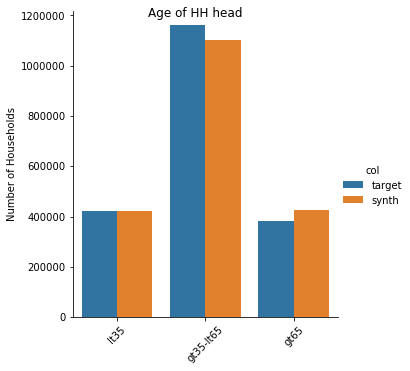

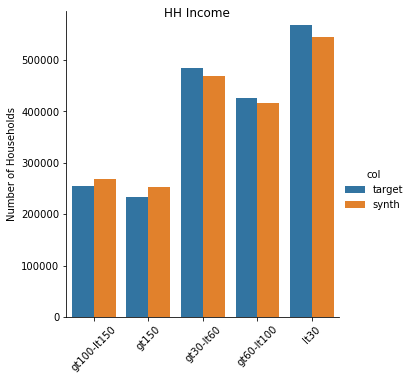

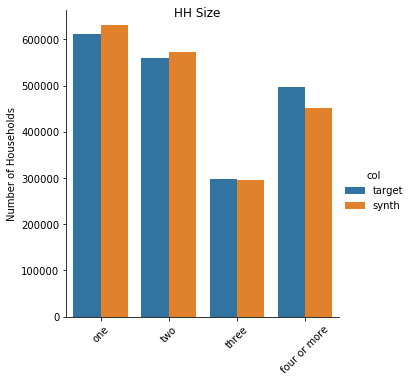

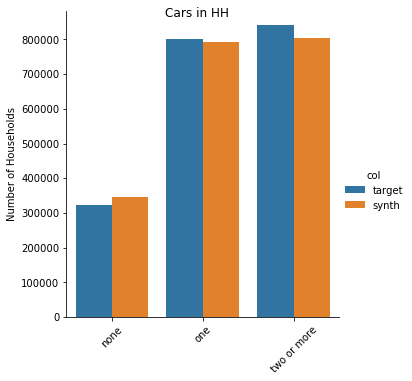

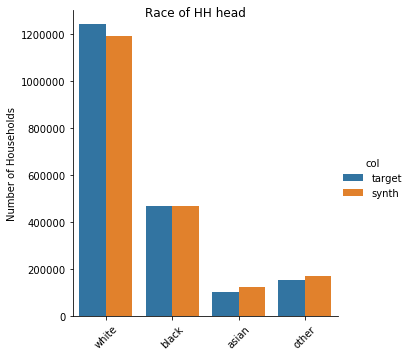

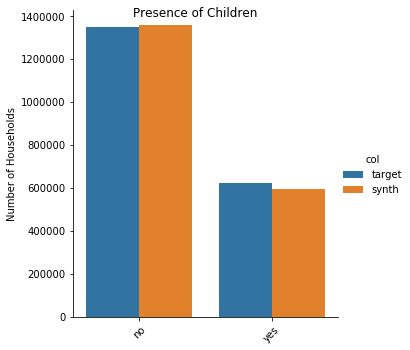

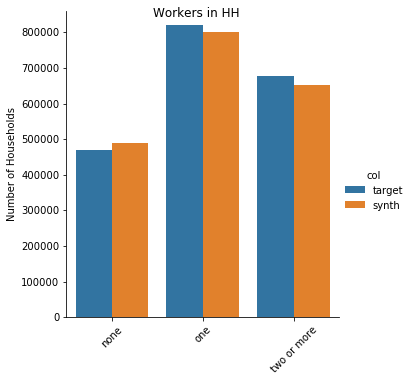

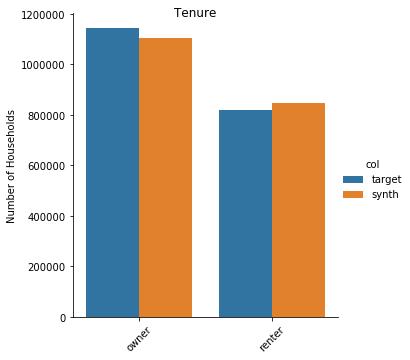

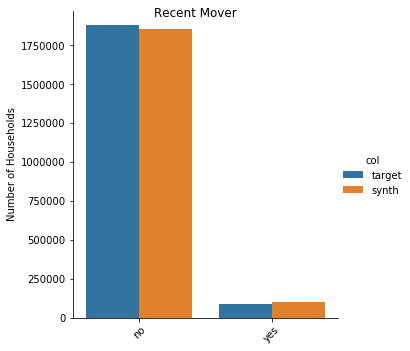

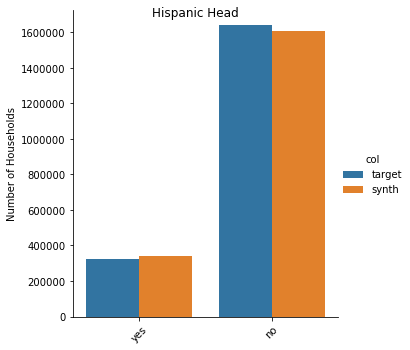

In [74]:
graph_sets = {'Age of HH head': ['hh_age_of_head_lt35','hh_age_of_head_gt35-lt65','hh_age_of_head_gt65'],
    'HH Income': ['hh_income_gt100-lt150', 'hh_income_gt150',
        'hh_income_gt30-lt60','hh_income_gt60-lt100','hh_income_lt30'],
    'HH Size': ['hh_size_one','hh_size_two','hh_size_three','hh_size_four or more'],
    'Cars in HH': ['hh_cars_none','hh_cars_one','hh_cars_two or more'],
    'Race of HH head': ['hh_race_of_head_white','hh_race_of_head_black',
        'hh_race_of_head_asian','hh_race_of_head_other'],
    'Presence of Children': ['hh_children_no','hh_children_yes'],
    'Workers in HH': ['hh_workers_none','hh_workers_one','hh_workers_two or more'],
        'Tenure': ['tenure_owner','tenure_renter'],
    'Recent Mover': ['recent_mover_no','recent_mover_yes'],
    'Hispanic Head': ['hispanic_head_yes','hispanic_head_no']}
print('VALIDATION OF HOUSEHOLD ATTRIBUTES')
for key, value in graph_sets.items():
    x = value
    target_hh_slice=hh_target3[x]
    synth_hh_slice= synth_hh_totals1[x]
    synth_hh_slice.index=target_hh_slice.index
    
    df = pd.concat([synth_hh_slice.T, target_hh_slice.T], axis=0, ignore_index=False)
    df['col'] = (len(synth_hh_slice.T)*(0,) + len(target_hh_slice.T)*(1,))
    df.reset_index(inplace=True)
    df.rename(columns = {0:'Number of Households'}, inplace = True)
    df['col']= df['col'].map(lambda x: 'target' if x==0 else 'synth')
    labels = [lab[lab.rindex('_')+1:] for lab in value]
    ax = sns.factorplot(data=df,x='index', y='Number of Households', hue='col', kind='bar')
    ax.set_xticklabels(labels)
    ax.set_xlabels('')
    plt.suptitle(key)
    plt.xticks(rotation=45)
    plt.show()

VALIDATION OF POPULATION ATTRIBUTES


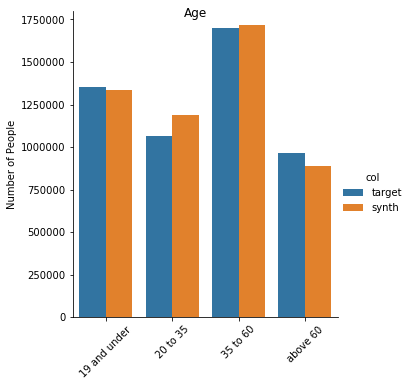

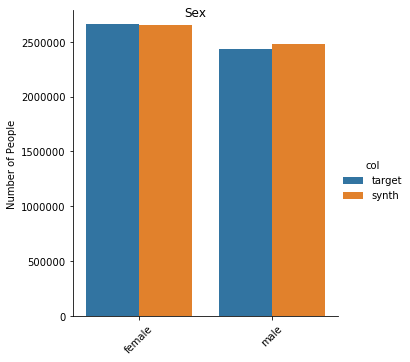

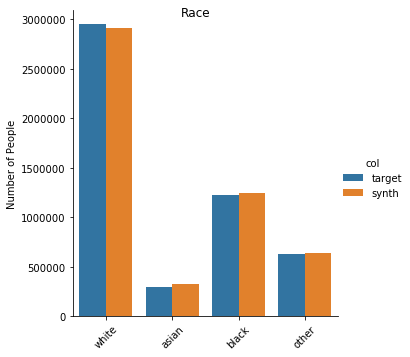

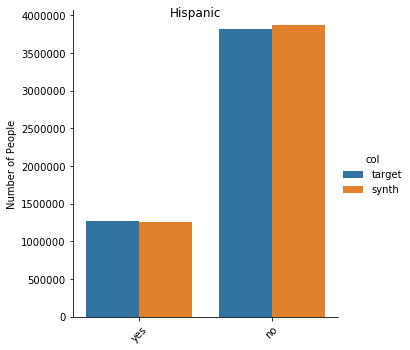

In [111]:
graph_sets = {    'Age': ['person_age_19 and under','person_age_20 to 35','person_age_35 to 60','person_age_above 60'],
    'Sex': ['person_sex_female', 'person_sex_male'],
    'Race': ['race_white','race_asian', u'race_black','race_other'],
    'Hispanic': ['hispanic_yes','hispanic_no']}
print('VALIDATION OF POPULATION ATTRIBUTES')
for key, value in graph_sets.items():
    x = value
    target_hh_slice=p_target3[x]
    synth_hh_sclice= synth_p_totals1[x]
    synth_hh_sclice.index=target_hh_slice.index
    
    df = pd.concat([synth_hh_sclice.T, target_hh_slice.T], axis=0, ignore_index=False)
    df['col'] = (len(synth_hh_sclice.T)*(0,) + len(target_hh_slice.T)*(1,))
    df.reset_index(inplace=True)
    df.rename(columns = {0:'Number of People'}, inplace = True)
    df['col']= df['col'].map(lambda x: 'target' if x==0 else 'synth')
    labels = [lab[lab.rindex('_')+1:] for lab in value]
    ax = sns.factorplot(data=df,x='index', y='Number of People', hue='col', kind='bar')
    ax.set_xticklabels(labels)
    ax.set_xlabels('')
    plt.suptitle(key)
    plt.xticks(rotation=45)
    plt.show()